In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
df = pd.read_csv('~/Documents/Vu/AI/statistique_gens_par_cellule.csv')

print(df)

    71381 cells/ 500 genes  Min_cell  Max_cell  Mean_cell  \
0                     PDK4         0        26   0.295485   
1                    CCL26         0         9   0.043177   
2                   CX3CL1         0        62   0.350696   
3                      CD4         0        19   0.121741   
4                    SNAI2         0        15   0.235875   
..                     ...       ...       ...        ...   
495                  VEGFC         0        19   0.067371   
496                    IL4         0         3   0.033454   
497                  IL17A         0         3   0.016727   
498                  CXCR5         0         2   0.017161   
499                   IL21         0         2   0.011095   

     1 to select/ 0 for non  random 0-1  random 0-1 fixed   fake prot levels  
0                         0    0.886975          0.392224                  0  
1                         0    0.446656          0.853176                  0  
2                         0   

In [4]:
# Generate synthetic protein dataset
# import random

# syntprotein = pd.read_csv('~/Documents/Vu/AI/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv')
# print(syntprotein)

# l_random = [random.random() for i in range(12)]
# list_genes = ['cell', 'CD4', 'LAG3', 'GZMB', 'HAVCR2', 'CD8A', 'MYC', 'TIGIT', 'CD8B', 'VSIR', 'CD163', 'CD226', 'CD68']

# for i, gene in enumerate(syntprotein.columns[:]):
#     if gene not in list_genes:
#         syntprotein.drop(gene, inplace=True, axis=1)
        
# for i in range(syntprotein.shape[0]):
#     syntprotein.loc[i, syntprotein.columns[1:]] *= l_random
    
# print(syntprotein.shape[0])
# print(syntprotein.loc[0, syntprotein.columns[1:]])
# syntprotein.to_csv('Synthetic_protein.csv', index = True)

In [5]:
syntprotein = pd.read_csv('~/Documents/Vu/data/Synthetic_protein.csv')
syntprotein.drop('Unnamed: 0', inplace=True, axis=1)
print(syntprotein)

        cell  CD4  LAG3      GZMB  HAVCR2  CD8A       MYC     TIGIT  CD8B  \
0          0  0.0   0.0  0.000000     0.0   0.0  0.000000  0.000000   0.0   
1          1  0.0   0.0  0.000000     0.0   0.0  0.000000  0.000000   0.0   
2          2  0.0   0.0  0.000000     0.0   0.0  0.000000  0.000000   0.0   
3          3  0.0   0.0  0.000000     0.0   0.0  1.033913  0.000000   0.0   
4          4  0.0   0.0  0.000000     0.0   0.0  0.000000  0.000000   0.0   
...      ...  ...   ...       ...     ...   ...       ...       ...   ...   
71376  71376  0.0   0.0  0.202634     0.0   0.0  0.295404  0.000000   0.0   
71377  71377  0.0   0.0  0.000000     0.0   0.0  1.624721  0.000000   0.0   
71378  71378  0.0   0.0  0.000000     0.0   0.0  0.147702  0.981027   0.0   
71379  71379  0.0   0.0  0.000000     0.0   0.0  0.738510  0.000000   0.0   
71380  71380  0.0   0.0  0.000000     0.0   0.0  0.000000  0.000000   0.0   

           VSIR  CD163  CD226  CD68  
0      0.000000    0.0    0.0   0.0  

In [6]:
mARN_df = pd.read_csv('~/Documents/Vu/AI/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv')
mARN_df.drop('cell', inplace=True, axis=1)
print(mARN_df)

       PDK4  CCL26  CX3CL1  CD4  SNAI2  TNFRSF17  ICAM3  TBX21  FAP  NFKB2  \
0       0.0    0.0     0.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   
1       0.0    0.0     0.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   
2       0.0    0.0     0.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   
3       0.0    0.0     1.0  0.0    0.0       1.0    0.0    0.0  0.0    4.0   
4       0.0    0.0     0.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   
...     ...    ...     ...  ...    ...       ...    ...    ...  ...    ...   
71376   1.0    0.0     0.0  0.0    1.0       0.0    1.0    0.0  0.0    0.0   
71377   0.0    0.0     0.0  0.0    0.0       1.0    0.0    0.0  0.0    2.0   
71378   0.0    0.0     2.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   
71379   0.0    0.0     0.0  0.0    0.0       0.0    1.0    0.0  0.0    1.0   
71380   0.0    0.0     0.0  0.0    0.0       0.0    0.0    0.0  0.0    0.0   

       ...  Blank-20  Blank-31  Blank-34  CXCR5  IL21  Blank-17

In [7]:
tensor = torch.Tensor(mARN_df.values)
dataset = TensorDataset(tensor)
# Diviser les données en ensembles d'entraînement et de test
train_size = int(0.8 * len(tensor))  # 80% des données pour l'entraînement
test_size = len(tensor) - train_size  # 20% des données pour le test
X_train, X_test = random_split(tensor, [train_size, test_size])

train_dataloader = DataLoader(X_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=64, shuffle=False)

In [8]:
print(len(X_train))
len(train_dataloader)

57104


893

In [24]:
class AutoEncoder(nn.Module):
    def __init__(self):
#         super(AutoEncoder, self).__init__()
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
for data in train_dataloader:
    print(data[1].shape)
    break
print(len(train_dataloader))
print(data.shape)

torch.Size([550])
893
torch.Size([64, 550])


In [27]:
model = AutoEncoder().to(device)

# Define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Losses=[]
# Training the auto encoder
num_epochs = 40
for epoch in range(num_epochs):
    loss = 0
    for (data, _) in train_dataloader:
        # Move the data to the device
        data = data.reshape(-1, 784)
        data = data.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data)
   
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += loss.item()

    Losses.append(loss / len(train_dataloader))
    
    # Display the loss at each epoch
    print(f'Epoch : {epoch+1}/{num_epochs}, Loss = {Losses[-1]:.4f}')

Epoch : 1/40, Loss = 0.0001
Epoch : 2/40, Loss = 0.0001
Epoch : 3/40, Loss = 0.0000
Epoch : 4/40, Loss = 0.0000
Epoch : 5/40, Loss = 0.0000
Epoch : 6/40, Loss = 0.0000
Epoch : 7/40, Loss = 0.0000
Epoch : 8/40, Loss = 0.0001
Epoch : 9/40, Loss = 0.0000
Epoch : 10/40, Loss = 0.0000
Epoch : 11/40, Loss = 0.0000
Epoch : 12/40, Loss = 0.0000
Epoch : 13/40, Loss = 0.0000
Epoch : 14/40, Loss = 0.0000
Epoch : 15/40, Loss = 0.0000
Epoch : 16/40, Loss = 0.0000
Epoch : 17/40, Loss = 0.0000
Epoch : 18/40, Loss = 0.0000
Epoch : 19/40, Loss = 0.0000
Epoch : 20/40, Loss = 0.0000
Epoch : 21/40, Loss = 0.0000
Epoch : 22/40, Loss = 0.0000
Epoch : 23/40, Loss = 0.0000
Epoch : 24/40, Loss = 0.0000
Epoch : 25/40, Loss = 0.0000
Epoch : 26/40, Loss = 0.0000
Epoch : 27/40, Loss = 0.0000
Epoch : 28/40, Loss = 0.0000
Epoch : 29/40, Loss = 0.0000
Epoch : 30/40, Loss = 0.0000
Epoch : 31/40, Loss = 0.0000
Epoch : 32/40, Loss = 0.0000
Epoch : 33/40, Loss = 0.0000
Epoch : 34/40, Loss = 0.0000
Epoch : 35/40, Loss = 0

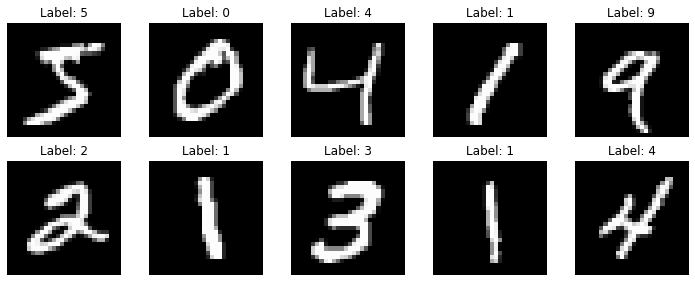

60000


In [23]:
# Display some sample images
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
# for i in range(2):
#     for j in range(5):
#         index = i * 5 + j
#         image, label = train_dataset[index]
#         axes[i, j].imshow(image.reshape(28,28), cmap='gray')
#         axes[i, j].set_title(f'Label: {label}')
#         axes[i, j].axis('off')

# plt.tight_layout()
# plt.show()
# print(len(train_dataset))

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [27]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_size = 784
total_steps = len(train_dataloader)
num_epochs = 25
Losses = []
for epoch in range(num_epochs):
    loss = 0
    
    for i, (images, _) in enumerate(train_dataloader):
        # Reshape images to 1D tensor
        images = images.reshape(-1, input_size)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item()

    Losses.append(loss / len(train_dataloader))
    
    # Display the loss at each epoch
    print(f'Epoch : {epoch+1}/{num_epochs}, Loss = {Losses[-1]:.7f}')



Epoch : 1/25, Loss = 0.0000594
Epoch : 2/25, Loss = 0.0000531
Epoch : 3/25, Loss = 0.0000469
Epoch : 4/25, Loss = 0.0000456
Epoch : 5/25, Loss = 0.0000444
Epoch : 6/25, Loss = 0.0000416
Epoch : 7/25, Loss = 0.0000502
Epoch : 8/25, Loss = 0.0000446
Epoch : 9/25, Loss = 0.0000386
Epoch : 10/25, Loss = 0.0000387
Epoch : 11/25, Loss = 0.0000316
Epoch : 12/25, Loss = 0.0000331
Epoch : 13/25, Loss = 0.0000327
Epoch : 14/25, Loss = 0.0000399
Epoch : 15/25, Loss = 0.0000373
Epoch : 16/25, Loss = 0.0000343
Epoch : 17/25, Loss = 0.0000343
Epoch : 18/25, Loss = 0.0000456
Epoch : 19/25, Loss = 0.0000343
Epoch : 20/25, Loss = 0.0000311
Epoch : 21/25, Loss = 0.0000286
Epoch : 22/25, Loss = 0.0000336
Epoch : 23/25, Loss = 0.0000316
Epoch : 24/25, Loss = 0.0000310
Epoch : 25/25, Loss = 0.0000287


In [54]:
print(len(train_dataset))
print(len(train_dataloader))
input_size = 784
for i, (images, _) in enumerate(train_dataloader):
    print(images.shape)
    images = images.reshape(-1,input_size)
    images = images.to(device)
    print(images.shape)
    break

60000
938
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


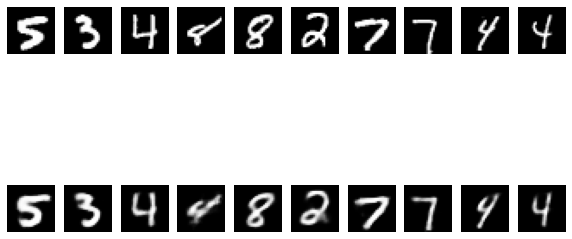

In [40]:
# Test the autoencoder
batch_size = 64
with torch.no_grad():
    # Generate a batch of random images
    #random_images = torch.randn(batch_size, input_size)
    for i, (images, _) in enumerate(train_dataloader):
        img = images
        break
    img = img.reshape(-1, input_size)
    decoded_images = model(img)

    # Display the original and reconstructed images
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(10, 6))
    for i in range(10):
        axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

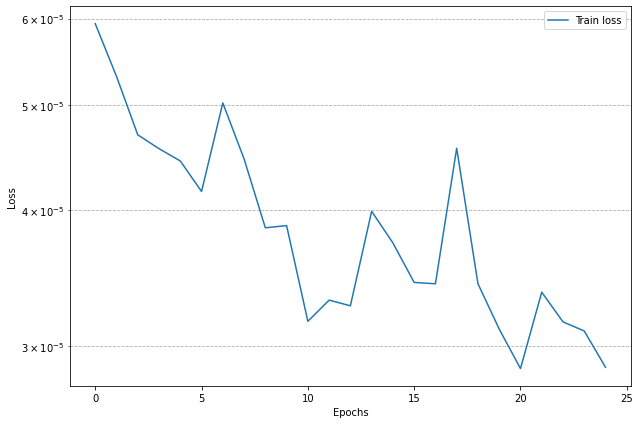

In [41]:
plt.figure(figsize=(9,6))
L = []
for l in Losses:
    loss_batch = l.detach().cpu().numpy()
    L.append(loss_batch)
plt.semilogy(L, label='Train loss')
# plt.semilogy(val_loss_log, label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(axis="y", which="minor", linestyle="--")
# plt.grid(axis="y", which="major")
plt.tight_layout()